# AutoEncoder Implementation in PyTorch

In [ ]:
# Autoencoder (AE)
# - Dataset: MNIST
# - Train/Val split: 70/30 of the 60k "train" file
# - Test: fixed 10k "t10k" file
# - Conv AE, AdamW, cosine schedule, AMP, early stopping
# - Saves best-by-val-RelL2
# - Evaluates Relative L1/L2 on test
# - Visualizes worst/best/median test reconstructions

In [2]:
# Imports
import struct, time, math, json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
#%pip install -q "numpy<2.0"
import numpy as np
print("NumPy version:", np.__version__)

NumPy version: 2.0.1


In [4]:
# A.1 Config
class Cfg:
    ROOT = Path(".")

    DATA_DIR  = ROOT / "mnist"
    TRAIN_DIR = DATA_DIR / "train"
    TEST_DIR  = DATA_DIR / "test"

    # Split
    TRAIN_FRACTION = 0.70

    # Training
    BATCH_SIZE   = 256
    EPOCHS       = 10
    LR           = 1e-3
    WEIGHT_DECAY = 1e-4
    NUM_WORKERS  = 0
    AMP          = True

    # Early stopping
    PATIENCE = 2
    MIN_DELTA = 1e-5
    
    # Outputs
    OUT_DIR  = ROOT / "output"
    EXP_NAME = time.strftime("ae_%Y%m%d_%H%M%S")

    # Repro
    SEED = 42

cfg = Cfg()

# run folder for saving
exp_dir = cfg.OUT_DIR / cfg.EXP_NAME
exp_dir.mkdir(parents=True, exist_ok=True)

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(cfg.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(cfg.SEED)

print("Device     :", device)
print("Train dir  :", cfg.TRAIN_DIR.resolve())
print("Test dir   :", cfg.TEST_DIR.resolve())
print("Run folder :", exp_dir.resolve())


Device     : cpu
Train dir  : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train
Test dir   : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test
Run folder : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/ae_20250925_001234


In [5]:
# A.2 Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

inv_normalize = transforms.Normalize(mean=[-1*0.5/0.5], std=[1/0.5])


In [6]:
# A.3 IDX helpers and dataset
def _open_idx(path: Path):
    """Opens .idx or .idx.gz transparently."""
    return gzip.open(path, "rb") if path.suffix == ".gz" else open(path, "rb")

def parse_idx_images(path: Path) -> np.ndarray:
    """Parse IDX image file (magic 2051) → numpy uint8 array (N, 28, 28)."""
    with _open_idx(path) as f:
        header = f.read(16)
        if len(header) != 16:
            raise RuntimeError(f"Malformed IDX header in {path}")
        magic, num, rows, cols = struct.unpack(">IIII", header)
        if magic != 2051:
            raise RuntimeError(f"Invalid IDX magic {magic} in {path} (expected 2051)")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(num, rows, cols)

class MNISTIdxDataset(Dataset):
    """Wraps (N,28,28) uint8 arrays as a torch Dataset; target == input (AE)."""
    def __init__(self, images: np.ndarray, transform=None):
        self.images = images
        self.transform = transform
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx], mode="L")
        x = self.transform(img) if self.transform else transforms.ToTensor()(img)
        return x, x


In [7]:
# A.4 IDX files
train_candidates = [
    "train-images.idx3-ubyte",
    "train-images-idx3-ubyte.gz",
]
test_candidates = [
    "t10k-images.idx3-ubyte",
    "t10k-images-idx3-ubyte.gz",
]

def find_idx_in_dir(dir_path: Path, candidates):
    for fn in candidates:
        p = dir_path / fn
        if p.exists(): return p
    for p in dir_path.rglob("*"):
        if p.is_file() and p.name in candidates:
            return p
    return None

train_dir = (cfg.TRAIN_DIR).resolve()
test_dir  = (cfg.TEST_DIR).resolve()

train_idx_path = find_idx_in_dir(train_dir, train_candidates)
test_idx_path  = find_idx_in_dir(test_dir,  test_candidates)

print("Train dir :", train_dir)
print("Test dir  :", test_dir)
print("Train IDX :", train_idx_path)
print("Test  IDX :", test_idx_path)

if train_idx_path is None:
    raise RuntimeError("Could not find a train IDX in mnist/train. "
                       f"Expected one of: {', '.join(train_candidates)}")


Train dir : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train
Test dir  : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test
Train IDX : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train/train-images.idx3-ubyte
Test  IDX : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test/t10k-images.idx3-ubyte


In [8]:
# A.5 Load arrays, build splits, create dataloaders
g = torch.Generator().manual_seed(cfg.SEED)

# Load training IDX
train_images = parse_idx_images(train_idx_path)
print("Loaded train images:", train_images.shape)

# Load test IDX if present
test_images = None
if test_idx_path is not None:
    test_images = parse_idx_images(test_idx_path)
    print("Loaded test images :", test_images.shape)
else:
    print("No test IDX found")

# Build datasets/splits
if test_images is not None:
    full_ds = MNISTIdxDataset(train_images, transform=transform)
    test_ds = MNISTIdxDataset(test_images,  transform=transform)

    n_full  = len(full_ds)                 #  60_000
    n_train = int(cfg.TRAIN_FRACTION * n_full)   # 70% of 60k = 42k by default
    n_val   = n_full - n_train                    # 18k
    train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=g)
else:
    # Fallback: only one IDX → 70/15/15
    full_ds = MNISTIdxDataset(train_images, transform=transform)
    n_full  = len(full_ds)
    n_train = int(cfg.TRAIN_FRACTION * n_full)   # 70%
    n_rest  = n_full - n_train                   # 30%
    n_val   = n_rest // 2                        # 15%
    n_test  = n_rest - n_val                     # 15%
    train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=g)

print(f"Final splits → Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# DataLoaders
pin = True
train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,
                          num_workers=cfg.NUM_WORKERS, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=cfg.BATCH_SIZE, shuffle=False,
                          num_workers=cfg.NUM_WORKERS, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=cfg.BATCH_SIZE, shuffle=False,
                          num_workers=cfg.NUM_WORKERS, pin_memory=pin)


Loaded train images: (60000, 28, 28)
Loaded test images : (10000, 28, 28)
Final splits → Train: 42000 | Val: 18000 | Test: 10000


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/1511197074.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


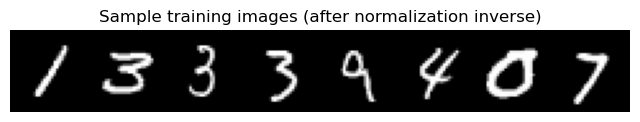

In [9]:
# A.6 Quick sanity check
xb, _ = next(iter(train_loader))
xb_vis = inv_normalize(xb[:8].cpu()).clamp(0,1)
grid = make_grid(xb_vis, nrow=8, padding=2)
plt.figure(figsize=(8,2))
plt.axis('off')
plt.title("Sample training images (after normalization inverse)")
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
plt.show()


In [10]:
# B. Model (Conv Autoencoder)
# - U-Net–like AE with light skip connections
# - SiLU activations + GroupNorm (stable)
# - Output uses `tanh` to match inputs normalized to [-1, 1]

# B.1 Define model
class Down(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1),
            nn.GroupNorm(8, cout),
            nn.SiLU(),
            nn.Conv2d(cout, cout, 3, padding=1),
            nn.GroupNorm(8, cout),
            nn.SiLU(),
        )
        self.pool = nn.Conv2d(cout, cout, 2, stride=2)  # downsample by 2
    def forward(self, x):
        x = self.conv(x)
        y = self.pool(x)
        return x, y   # return pre-pooled for skip

class Up(nn.Module):
    def __init__(self, in_c, skip_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)  # upsample by 2
        self.conv = nn.Sequential(
            nn.Conv2d(out_c + skip_c, out_c, 3, padding=1),
            nn.GroupNorm(8, out_c),
            nn.SiLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.GroupNorm(8, out_c),
            nn.SiLU(),
        )
    def forward(self, x, skip):
        x = self.up(x)
        # Defensive: if shapes differ by 1, center-crop the skip
        if x.shape[-2:] != skip.shape[-2:]:
            dh = skip.shape[-2] - x.shape[-2]
            dw = skip.shape[-1] - x.shape[-1]
            skip = skip[:, :, dh//2:skip.shape[-2]-(dh - dh//2),
                             dw//2:skip.shape[-1]-(dw - dw//2)]
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.inp = nn.Conv2d(1, 32, 3, padding=1)

        # Encoder (2 downs: 28→14→7)
        self.d1 = Down(32, 64)     # s1: 64 ch @ 28×28
        self.d2 = Down(64, 128)    # s2: 128 ch @ 14×14

        # Bottleneck on 7×7, expand channels for capacity
        self.to_bot = nn.Conv2d(128, 256, 3, padding=1)
        self.mid = nn.Sequential(
            nn.GroupNorm(16, 256),
            nn.SiLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.GroupNorm(16, 256),
            nn.SiLU(),
        )

        # Decoder (2 ups: 7→14→28)
        self.u2 = Up(in_c=256, skip_c=128, out_c=128)  # 7→14, merge with s2
        self.u1 = Up(in_c=128, skip_c=64,  out_c=64)   # 14→28, merge with s1

        # Output head
        self.out = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 1, 1),
            nn.Tanh(),  # match inputs normalized to [-1,1]
        )

    def encode(self, x):
        x = self.inp(x)            # 32 @ 28×28
        s1, x = self.d1(x)         # s1: 64 @ 28×28, x: 64 @ 14×14
        s2, x = self.d2(x)         # s2: 128 @ 14×14, x: 128 @ 7×7
        z = self.to_bot(x)         # 256 @ 7×7
        z = self.mid(z)            # 256 @ 7×7
        return z, (s1, s2)

    def decode(self, z, skips):
        s1, s2 = skips
        x = self.u2(z, s2)         # 128 @ 14×14
        x = self.u1(x, s1)         # 64  @ 28×28
        return self.out(x)         # 1   @ 28×28

    def forward(self, x):
        z, skips = self.encode(x)
        return self.decode(z, skips)

# Recreate model and sanity check shapes
model = ConvAE().to(device)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)


Model params (M): 1.982977


In [11]:
# B.2 quick shape test
model.eval()
xb, _ = next(iter(train_loader))
xb = xb.to(device)[:8]
with torch.no_grad():
    xhat = model(xb)
print("Input shape :", tuple(xb.shape))
print("Output shape:", tuple(xhat.shape))
assert xhat.shape == xb.shape, "AE output must match input shape (N,1,28,28)"


Input shape : (8, 1, 28, 28)
Output shape: (8, 1, 28, 28)


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/1511197074.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


In [12]:
# C. Training
# - Optimizer: AdamW
# - Scheduler: CosineAnnealingWarmRestarts
# - Mixed precision (AMP)
# - Early stopping on **validation Relative L2**
# - Saves:
#     - `best_model.pt`  (weights only)
#     - `best_val.ckpt`  (full checkpoint incl. optimizer)
#     - `last.ckpt`      (final state)
#     - `history.json`   (training curves)

In [13]:
#C.1 Setup optimizer / losses / scheduler / scaler
import numpy as np

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.AMP)

def recon_loss(xhat, x):
    """Hybrid reconstruction loss: 0.5*L1 + 0.5*L2 (good balance for crispness)."""
    l1 = F.l1_loss(xhat, x)
    l2 = F.mse_loss(xhat, x)
    return 0.5*l1 + 0.5*l2, l1.item(), l2.item()

def batch_relative_l2(xhat, x, eps=1e-12):
    """Mean over batch of ||x - x̂||2 / ||x||2."""
    diff = (xhat - x)
    num = torch.sqrt((diff**2).flatten(1).sum(1))
    den = torch.sqrt((x**2).flatten(1).sum(1) + eps)
    return (num / den).mean()

# paths to save
best_path_weights = exp_dir / "best_model.pt"
best_path_ckpt    = exp_dir / "best_val.ckpt"
last_path_ckpt    = exp_dir / "last.ckpt"

def save_ckpt(path, model, optimizer, epoch, metrics: dict):
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "metrics": metrics,
        "cfg": vars(cfg),
    }, path)


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/3751383074.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.AMP)
/Users/admin/opt/miniconda3/envs/ae-vae-vqvae/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [14]:
# C.2 Train with early stopping on val Relative L2
best_val = float("inf")
no_improve = 0
history = {"train_loss": [], "val_relL2": []}

for epoch in range(1, cfg.EPOCHS + 1):
    # ---- Train ----
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=cfg.AMP):
            xhat = model(xb)
            loss, _, _ = recon_loss(xhat, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_losses.append(loss.item())
    scheduler.step(epoch)

    # ---- Validate (Relative L2) ----
    model.eval()
    val_metrics = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xhat = model(xb)
            val_metrics.append(batch_relative_l2(xhat, yb).item())
    val_relL2 = float(np.mean(val_metrics)) if val_metrics else float("inf")
    train_loss = float(np.mean(train_losses)) if train_losses else float("inf")

    history["train_loss"].append(train_loss)
    history["val_relL2"].append(val_relL2)
    print(f"Epoch {epoch:03d} | train {train_loss:.5f} | val RelL2 {val_relL2:.5f}")

    # ---- Early stopping & best checkpoint ----
    if best_val - val_relL2 > cfg.MIN_DELTA:
        best_val = val_relL2
        no_improve = 0
        # save both full ckpt and weights-only
        save_ckpt(best_path_ckpt, model, optimizer, epoch, {"val_relL2": val_relL2})
        torch.save(model.state_dict(), best_path_weights)
    else:
        no_improve += 1
        if no_improve >= cfg.PATIENCE:
            print("Early stopping.")
            break

# Save last & history
save_ckpt(last_path_ckpt, model, optimizer, epoch, {"val_relL2": val_relL2})
with open(exp_dir / "history.json", "w") as f:
    json.dump(history, f, indent=2)

# Load best weights for downstream evaluation
model.load_state_dict(torch.load(best_path_weights, map_location=device))
model.eval()
print("Loaded best weights from:", best_path_weights.resolve())


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/1511197074.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")
/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/3134607689.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.AMP):
/Users/admin/opt/miniconda3/envs/ae-vae-vqvae/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 001 | train 0.02239 | val RelL2 0.02708
Epoch 002 | train 0.00366 | val RelL2 0.01618
Epoch 003 | train 0.00278 | val RelL2 0.01199
Epoch 004 | train 0.00216 | val RelL2 0.01120
Epoch 005 | train 0.00159 | val RelL2 0.00884
Epoch 006 | train 0.00124 | val RelL2 0.00650
Epoch 007 | train 0.00100 | val RelL2 0.00610
Epoch 008 | train 0.00088 | val RelL2 0.00514
Epoch 009 | train 0.00082 | val RelL2 0.00494
Epoch 010 | train 0.00080 | val RelL2 0.00489
Loaded best weights from: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/ae_20250925_001234/best_model.pt


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/3134607689.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path_we

In [15]:
#D. Test metrics
# Computes Relative L1 and Relative L2 on the **test** set using the *best* checkpoint.

# D.1 Ensure best weights are loaded (defensive)
from pathlib import Path
import json

try:
    _ = best_path_weights
except NameError:
    best_path_weights = exp_dir / "best_model.pt"

model.load_state_dict(torch.load(best_path_weights, map_location=device))
model.eval()

def per_sample_rel_errors(xhat, x, eps=1e-12):
    diff = (xhat - x)
    relL1 = diff.abs().flatten(1).sum(1) / (x.abs().flatten(1).sum(1) + eps)
    relL2 = torch.sqrt((diff**2).flatten(1).sum(1)) / (torch.sqrt((x**2).flatten(1).sum(1) + eps))
    return relL1, relL2

all_relL1, all_relL2 = [], []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        xhat = model(xb)
        r1, r2 = per_sample_rel_errors(xhat, xb)
        all_relL1.append(r1.cpu()); all_relL2.append(r2.cpu())

all_relL1 = torch.cat(all_relL1)
all_relL2 = torch.cat(all_relL2)

test_relL1 = all_relL1.mean().item()
test_relL2 = all_relL2.mean().item()

print(f"Test Relative L1: {test_relL1:.6f}")
print(f"Test Relative L2: {test_relL2:.6f}")

# Save metrics
with open(exp_dir / "test_metrics.json", "w") as f:
    json.dump({"relL1": test_relL1, "relL2": test_relL2}, f, indent=2)
print("Saved metrics to:", (exp_dir / "test_metrics.json").resolve())


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/26438114.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path_weig

Test Relative L1: 0.001654
Test Relative L2: 0.004805
Saved metrics to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/ae_20250925_001234/test_metrics.json


In [16]:
# E. Visualize worst / median / best
# Ranks test samples by Relative L2 and shows side-by-side (original | recon).

#E.1 Collect reconstructions and errors over the test set
import numpy as np
import matplotlib.pyplot as plt

images, recons, errs = [], [], []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        xhat = model(xb)
        _, r2 = per_sample_rel_errors(xhat, xb)
        images.append(xb.cpu()); recons.append(xhat.cpu()); errs.append(r2.cpu())

images = torch.cat(images)   # (N,1,28,28)
recons = torch.cat(recons)
errs   = torch.cat(errs)

worst_idx  = torch.argmax(errs).item()
best_idx   = torch.argmin(errs).item()
median_val = torch.median(errs).item()
median_idx = (errs - median_val).abs().argmin().item()

print("Indices → Best:", best_idx, "| Median:", median_idx, "| Worst:", worst_idx)


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_9245/1511197074.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


Indices → Best: 7686 | Median: 8734 | Worst: 5734


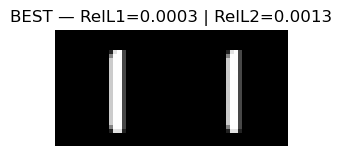

Saved best pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/ae_20250925_001234/test_best_pair.png


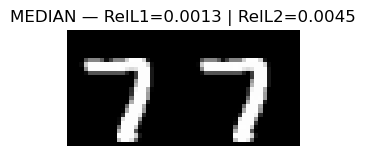

Saved median pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/ae_20250925_001234/test_median_pair.png


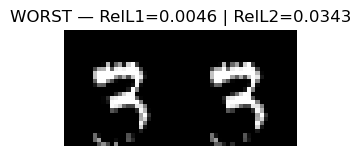

Saved worst pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/ae_20250925_001234/test_worst_pair.png


In [17]:
# E.2 Plot helper and save images
def show_pair(orig, recon, title, save_path=None):
    o = inv_normalize(orig).clamp(0,1).squeeze(0)   # (H,W)
    r = inv_normalize(recon).clamp(0,1).squeeze(0)  # (H,W)
    both = torch.cat([o, r], dim=-1)                # side-by-side

    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.title(title)
    plt.imshow(both, cmap='gray')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=160)
    plt.show()

with torch.no_grad():
    for label, idx in [("BEST", best_idx), ("MEDIAN", median_idx), ("WORST", worst_idx)]:
        x  = images[idx:idx+1]
        xr = recons[idx:idx+1]
        r1, r2 = per_sample_rel_errors(xr, x)
        fp = exp_dir / f"test_{label.lower()}_pair.png"
        show_pair(x[0], xr[0], f"{label} — RelL1={r1.item():.4f} | RelL2={r2.item():.4f}", fp)
        print(f"Saved {label.lower()} pair to:", fp.resolve())
